In [ ]:
import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler


In [4]:
%matplotlib inline
matplotlib.style.use('ggplot')
env = gym.envs.make("MountainCar-v0")

[2019-02-19 09:03:51,838] Making new env: MountainCar-v0
/Users/jaroslaw/miniconda3/envs/3.6/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Cartpole이 학습하는 것을 보려면 "True"로 바꿀 것
        self.render = True

        # state와 action의 크기를 가져와서 모델을 생성하는데 사용함
        self.state_size = state_size
        self.action_size = action_size

        # Cartpole DQN 학습의 Hyper parameter 들
        # deque를 통해서 replay memory 생성
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        self.memory = deque(maxlen=10000)

        # 학습할 모델과 타겟 모델을 생성
        self.model = self.build_model()
        self.target_model = self.build_model()
        # 학습할 모델을 타겟 모델로 복사 --> 타겟 모델의 초기화(weight를 같게 해주고 시작해야 함)
        self.update_target_model()

    # Deep Neural Network를 통해서 Q Function을 근사
    # state가 입력, 각 행동에 대한 Q Value가 출력인 모델을 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 일정한 시간 간격마다 타겟 모델을 현재 학습하고 있는 모델로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 행동의 선택은 현재 네트워크에 대해서 epsilon-greedy 정책을 사용
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # <s,a,r,s'>을 replay_memory에 저장함
    def replay_memory(self, state, action, reward, next_state, done):
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        # print(len(self.memory))

    # replay memory에서 batch_size 만큼의 샘플들을 무작위로 뽑아서 학습
    def train_replay(self):
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            # 큐러닝에서와 같이 s'에서의 최대 Q Value를 가져옴. 단, 타겟 모델에서 가져옴
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        # 학습할 정답인 타겟과 현재 자신의 값의 minibatch를 만들고 그것으로 한 번에 모델 업데이트
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    # 저장한 모델을 불러옴
    def load_model(self, name):
        self.model.load_weights(name)

    # 학습된 모델을 저장함
    def save_model(self, name):
        self.model.save_weights(name)

In [8]:
class Estimator:
    """
    Value Function approximator. 
    """
    def __init__(self, initial_state):
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit(feature_state_fn(initial_state), [0])
            self.models.append(model)
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = feature_state_fn(s)
        if not a:
            return np.array([m.predict(features)[0] for m in self.models])
        else:
            return self.models[a].predict(features)[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = feature_state_fn(s)
        self.models[a].partial_fit(features, [y])


In [9]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, epsilon=None):
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        selected_action = best_action
        
        if epsilon is not None:
            action_probs = np.ones(nA, dtype=float) * epsilon / nA
            action_probs[selected_action] += (1.0 - epsilon)
            selected_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return selected_action
    
    return policy_fn


In [10]:
def q_learning(env, estimator, policy_fn, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        curr_epsilon = epsilon * epsilon_decay**i_episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        state = env.reset()
        
        for t in itertools.count():
                           
            action = policy_fn(state, curr_epsilon)

            next_state, reward, done, _ = env.step(action)
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)
        
            estimator.update(state, action, td_target)
            
            state = next_state

            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
                           
    return stats


In [16]:
estimator = Estimator(env.reset())
policy = make_epsilon_greedy_policy(estimator, env.action_space.n) 
stats = q_learning(env, estimator,policy, 180, epsilon=0.0)


Step 26 @ Episode 180/180 (-180.0))

In [12]:

policy_fn = make_epsilon_greedy_policy(estimator, env.action_space.n) 
observation = env.reset()
for t in range(100):
    env.render()
    action = policy_fn(observation)
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break


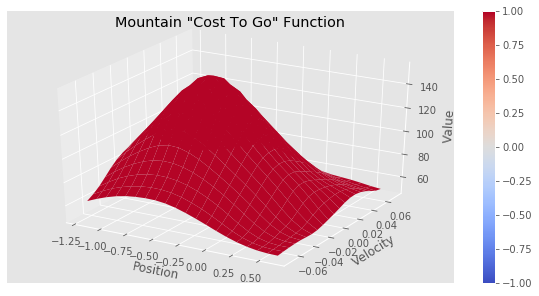

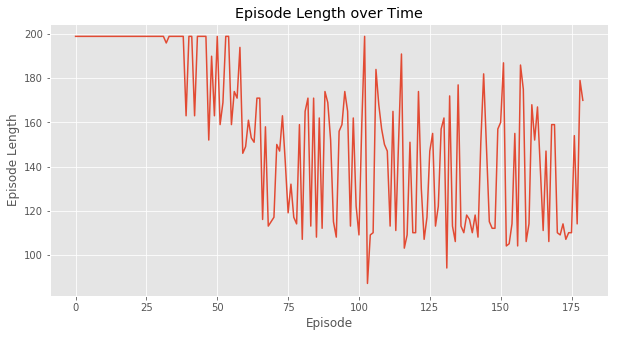

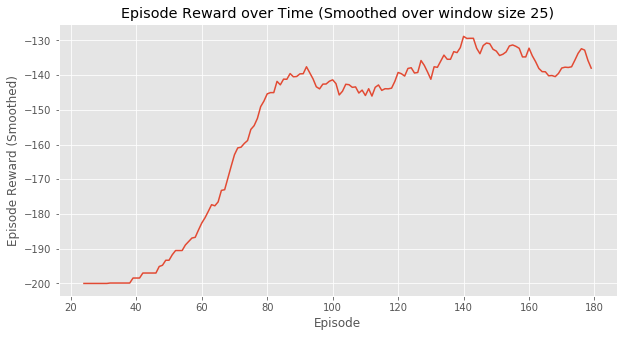

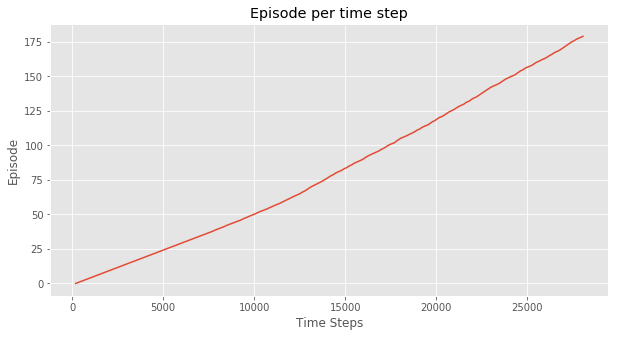

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)
